# Overview

This week's curriculum focuses in figuring out (and visualizing) what's special about a certain text (or collection of texts). We'll also learn about community detection in networks (that's how we'll get our groups of text)

* Tricks for raw text (NLPP, Chapter 3).
* Community Detection and info-boxes 
* Identifying important words in a document (TF-IDF)

In the first part, we will take a quick tour of NLPP1e's chapter 3, which is boring, but an amazing ressource that you'll keep returning to. Then we'll talk about how we can use simple statistics & machine learning to get text to show us what it's all about. We will even do a little visualization. 

In the latter parts we will go back to network science, discussing community detection, mixing in some NLP, and trying it all out on our very own dataset.


# Part 1: Processing real text (from out on the inter-webs)

Ok. So Chapter 3 in NLPP is all about working with text from the real world. Getting text from this internet, cleaning it, tokenizing, modifying (e.g. stemming, converting to lower case, etc) to get the text in shape to work with the NLTK tools you've already learned about - and many more. 

In the process we'll learn more about regular expressions, as well as unicode; something we've already been struggling with a little bit will now be explained in more detail. 
> 
> **Video lecture**: Short overview of chapter 3 + a few words about kinds of language processing that we don't address in this class. 
> 

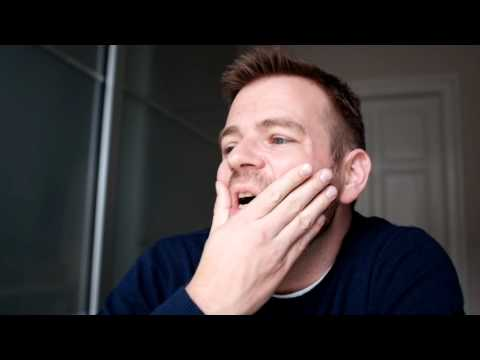

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("Rwakh-HXPJk",width=800, height=450)

> *Reading*: NLPP Chapter 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.9, and 3.10\. It's not important that you go in depth with everything here - the key think is that you *know that Chapter 3 of this book exists*, and that it's a great place to return to if you're ever in need of an explanation of regular expressions, unicode, or other topics that you forget as soon as you stop using them (and don't worry, I forget about those things too).
> 

In [4]:
import json
import urllib.request
import matplotlib.pyplot as plt
import re
import os
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import matplotlib.cm as cm
import numpy as np  
import community.community_louvain as community
from fa2_modified import ForceAtlas2
import pandas as pd

#### This part is only for the network buliding part from week4

In [5]:
# acquire the singer names list
def wikiinfo(title):
    baseurl =  "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    title = urllib.parse.urlencode({'titles': title})
    content = "prop=revisions&rvprop=content"
    dataformat ="format=json"
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, title, dataformat)
    wikiresponse = urllib.request.urlopen(query)
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    wikijson = json.loads(wikitext)
    return wikijson
wikijson = wikiinfo(title="List_of_country_music_performers")
#the content include the singer names
artist_content = wikijson['query']['pages']['328877']['revisions'][0]['*'] 
#extract the singer names
singer_names = re.findall(r'\*\[\[([^\|\(\]]+)', artist_content)
#remove the duplicate names and sort the names 
singer_names = sorted(set(singer_names)) 

In [6]:
# Extract [[...]] from the content and clean by removing parentheses and text after '|'
def get_connected_names(content):
    matches = re.findall(r'\[\[(.*?)\]\]', content)
    connected_names = [re.sub(r'\(.*?\)|\|.*', '', match).strip() for match in matches]
    return connected_names

# fliter the connected names that are in the singer_names list
def filter_connected_names(connected_names, singer_names):
    filtered_names = [name for name in connected_names if name in singer_names]
    return filtered_names

# Count the number of words in the content
def count_words(content):
    return len(re.findall(r'\b\w+\b', content))

def get_connected_map(folder_path, singer_names):
    # Create a undirected graph
    G = nx.Graph()
    folder_path = os.path.abspath(folder_path)
    
    # Iterate through all the .txt files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            
            if os.path.exists(file_path):
                
                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()
                
                # Use the file name as the node
                filename_m = os.path.splitext(filename)[0]
            
                # Check if the content is empty and set content_length accordingly
                content_length = count_words(content=content) if content.strip() else 0
                
                # Add the node with the content_length as an attribute
                G.add_node(filename_m, content_length=content_length)
                
                # Get and filter the connected names
                connected_names = get_connected_names(content)
                filtered_names = filter_connected_names(connected_names, singer_names)
                
                # Add edges for each filtered name
                for name in filtered_names:
                    G.add_edge(filename_m, name)
            else:
                print(f"File not found: {file_path}")

    return G


folder_path = 'wiki_pages'  
G = get_connected_map(folder_path, singer_names)
G.remove_edges_from(nx.selfloop_edges(G))  # remove self-loop edges
# the bascial information of the graph
print(f"Graph has {G.number_of_nodes()} \n nodes and {G.number_of_edges()} edges.")


Graph has 2102 
 nodes and 12997 edges.


# Part 2: Community detection

Before we get started on *network* communities, we'll grab some information on a different kind of communities based on information from Wikipedia. Specifically, the ``infoboxes``. An infobox is the little box usually displayed on the right when you open an artist's page. 

For example if you open the page for [Old 97's](https://en.wikipedia.org/wiki/Old_97%27s), you'll see that it contains info about their ***origin***, the ***genre***s of music they've been associated with, their ***year's active***, the record ***labels*** they've signed with, etc. All really interesting information if we want to understand the network of artists.

Today, we'll be playing with **genre**. It's not easy to extract information from the infoboxes, but one of your amazing TAs (Aliaksandr) has done the job for you already (he even parsed the html to get data for more artists).

> **You can download the genres [here](https://raw.githubusercontent.com/SocialComplexityLab/socialgraphs2024/refs/heads/main/files/artists_genres_dictionary.txt)**.



Now, let's watch a lecture to learn about communities. If you want all the details, I recommend you take a look at _Chapter 9_ in the _Network Science_ book ... but the video lecture below should be enough to get you started. 

**Note**: For this and the next exercise, work on the _undirected_ version of the network.

> **_Video Lecture_**: Communities in networks. 

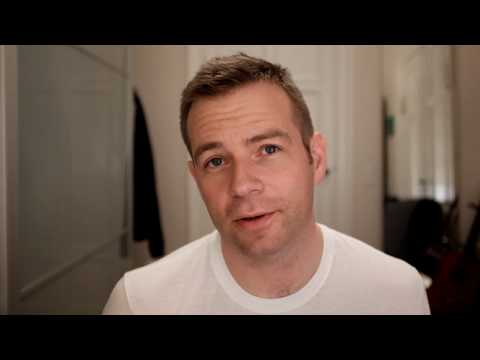

In [7]:
YouTubeVideo("FSRoqXw28RI",width=800, height=450)

*Exercise*: Use the concept of modularity to explore how _community-like_ the genres are.
> 
> * Explain the concept of modularity in your own words.
> * Work from the undirected version of the network, keeping only the nodes for which you have genre information in the file above. 
> * Now create your own partition of the network into genres.
>      * **Each node is simply characterized by the *first genre* in its list of genres**.
>      * Each community is the group of nodes that share the same genre.
>      * That's all you need, now calculate the modularity of this division of the network into genres.
>      * **Note**: Modularity is described in the _Network Science_ book, section 9.4.. Thus, use **equation 9.12** in the book to calculate the modularity _M_ of the partition described above. Are the genres good communities?
> * Spoiling your findings a little bit, an issue is the following: Almost all artists have the genre `country` as their first genre in the list, so by definition the network won't have very high modularity. What happens to the modularity if you grab the first genre *that's not `country`* as the genre-assignment for all nodes that have more than one genre? 

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code here. But do write your own explanation of modularity, and do try to implement a modularity on your own from eq 9.12 in the book.
</div>

modularity is the metrics to evaluate the quality of the community partition which offer a novel way to community detection.

$M_c = \frac{1}{2L} \sum_{(i,j) \in C_c} (A_{ij} - p_{ij}) = \frac{L_c}{L}-(\frac{k_c}{2L})^2$

$M = \sum_{c} M_c = \sum^{(n_c)}_{c=1}\frac{L_c}{L}-(\frac{k_c}{2L})^2$


From the result we can see that the modularity raised from 0.071 to 0.081, split the big community 'country' into other small communities increase the modularity therefore it a better partition for the network.

In [8]:
#remove the node that not in geners
# Load singer data from 'genres.txt'

with open('genres.txt', 'r') as f:
    genres_data = json.load(f)

# Get the singer names from the keys of the JSON object
singer_names_geners = [key for key in genres_data.keys()]

# Remove nodes from the graph that are not in the singer names from 'genres.txt'
nodes = list(G.nodes())
for node in nodes:
    if node not in singer_names_geners:
        G.remove_node(node)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 1602 nodes and 12121 edges.


In [9]:
#create the graph for the genres community question
G_genres = G
# assign each nodes as their first genre
node_genres = {}
for artist, genres in genres_data.items():
    node_genres[artist] = genres[0] if genres else 'unknown'
nx.set_node_attributes(G_genres, node_genres, 'genre')

# put the nodes into the corresponing communities
genre_communities = defaultdict(list)
for node, data in G_genres.nodes(data=True):
    genre = data.get('genre', 'unknown')
    genre_communities[genre].append(node)

# calculate the modularity
def calculate_modularity(G, communities):
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    A = nx.to_numpy_array(G, nodelist=G.nodes())  # adjacency matrix for whole network
    L = G.number_of_edges()
    degrees = dict(G.degree())
    modularity = 0.0

    for community in communities:
        indices = [node_to_index[node] for node in community] # indices of nodes in community
        subgraph = A[np.ix_(indices, indices)] # adjacency matrix for community
        ki = np.array([degrees[node] for node in community]) # degree of nodes in community

        # Sum over all pairs including i == j
        sum_Aij = np.sum(subgraph)
        sum_kikj = np.sum(np.outer(ki, ki)) / (2 * L)

        modularity += (sum_Aij - sum_kikj) # sum over all communities

    modularity /= (2 * L) # divide by 2L
    return modularity
    
M = calculate_modularity(G_genres, genre_communities.values())
print("modularity of the first genres(include contry):", M)

modularity of the first genres(include contry): 0.07133312987832495


In [10]:
#create the graph for the genres community question
G_genres_1 = G
# assign each nodes as their first genre, if the first genre is country, assign the second genre as the genre
node_genres = {}
for artist, genres in genres_data.items():
    if genres and genres[0] == 'country' and len(genres) > 1:
        non_country_genre = next((g for g in genres if g != 'country'), 'country')
        node_genres[artist] = non_country_genre
    else:
        node_genres[artist] = genres[0] if genres else 'unknown'
nx.set_node_attributes(G_genres_1, node_genres, 'genre')

# put the nodes into the corresponing communities
genre_communities = defaultdict(list)
for node, data in G.nodes(data=True):
    genre = data.get('genre', 'unknown')
    genre_communities[genre].append(node)

# calculate the modularity
M = calculate_modularity(G_genres_1, genre_communities.values())
print("modularity of the first genres(not include contry):", M)

modularity of the first genres(not include contry): 0.08174863937109242


*Exercise*: Community detection finding structral communities in the network
> * Again, work only with the subnetwork of nodes that have a genre according to Aliaksandr's list (that you downloaded above). 
> * Use [the Python Louvain-algorithm implementation](http://perso.crans.org/aynaud/communities/) to find communities each network. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the genres as communities? What does this comparison reveal about them?
>     * **Note**: This implementation is also available as Anaconda package. Install with `conda` as expained [here](https://anaconda.org/auto/python-louvain). 
>     * **Note**: You can also try the *Infomap* algorithm instead if you're curious. Go to [this page]. (http://www.mapequation.org/code.html) and search for 'python'. It's harder to install, but a better community detection algorithm.
> * What is the modularity of this partitioning of the network? Is it more community-like than the genres?
> * Visualize the network, using the Force Atlas algorithm (see Lecture 5, exercise 2).
>     * This time assign each node a different color based on its structural _community_.
>     * **Note**: If there's a lot of small communities, it's OK to only color the 5-10 largest communities (you can make the remaing nodes light gray or some netural color)
>     * Describe the structure you observe.

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here. 
</div>

In [11]:
# create a graph for Louvain community detection
G_Lou = G

# apply Louvain-algorithm
partition = community.best_partition(G_Lou)

# adjust the format of the partition for calculation of the modularity
result = defaultdict(list)
for key, value in partition.items():
    result[value].append(key)

M = calculate_modularity(G_Lou, result.values())
print("modularity of Louvain-algorithm:", M)

modularity of Louvain-algorithm: 0.36777053362479717


100%|██████████| 2000/2000 [02:58<00:00, 11.21it/s]
C:\Users\wuqiu\AppData\Local\Temp\ipykernel_22708\388149488.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', max(partition.values()) + 1)  # 动态调整色图范围


BarnesHut Approximation  took  19.05  seconds
Repulsion forces  took  152.85  seconds
Gravitational forces  took  0.47  seconds
Attraction forces  took  0.73  seconds
AdjustSpeedAndApplyForces step  took  1.94  seconds


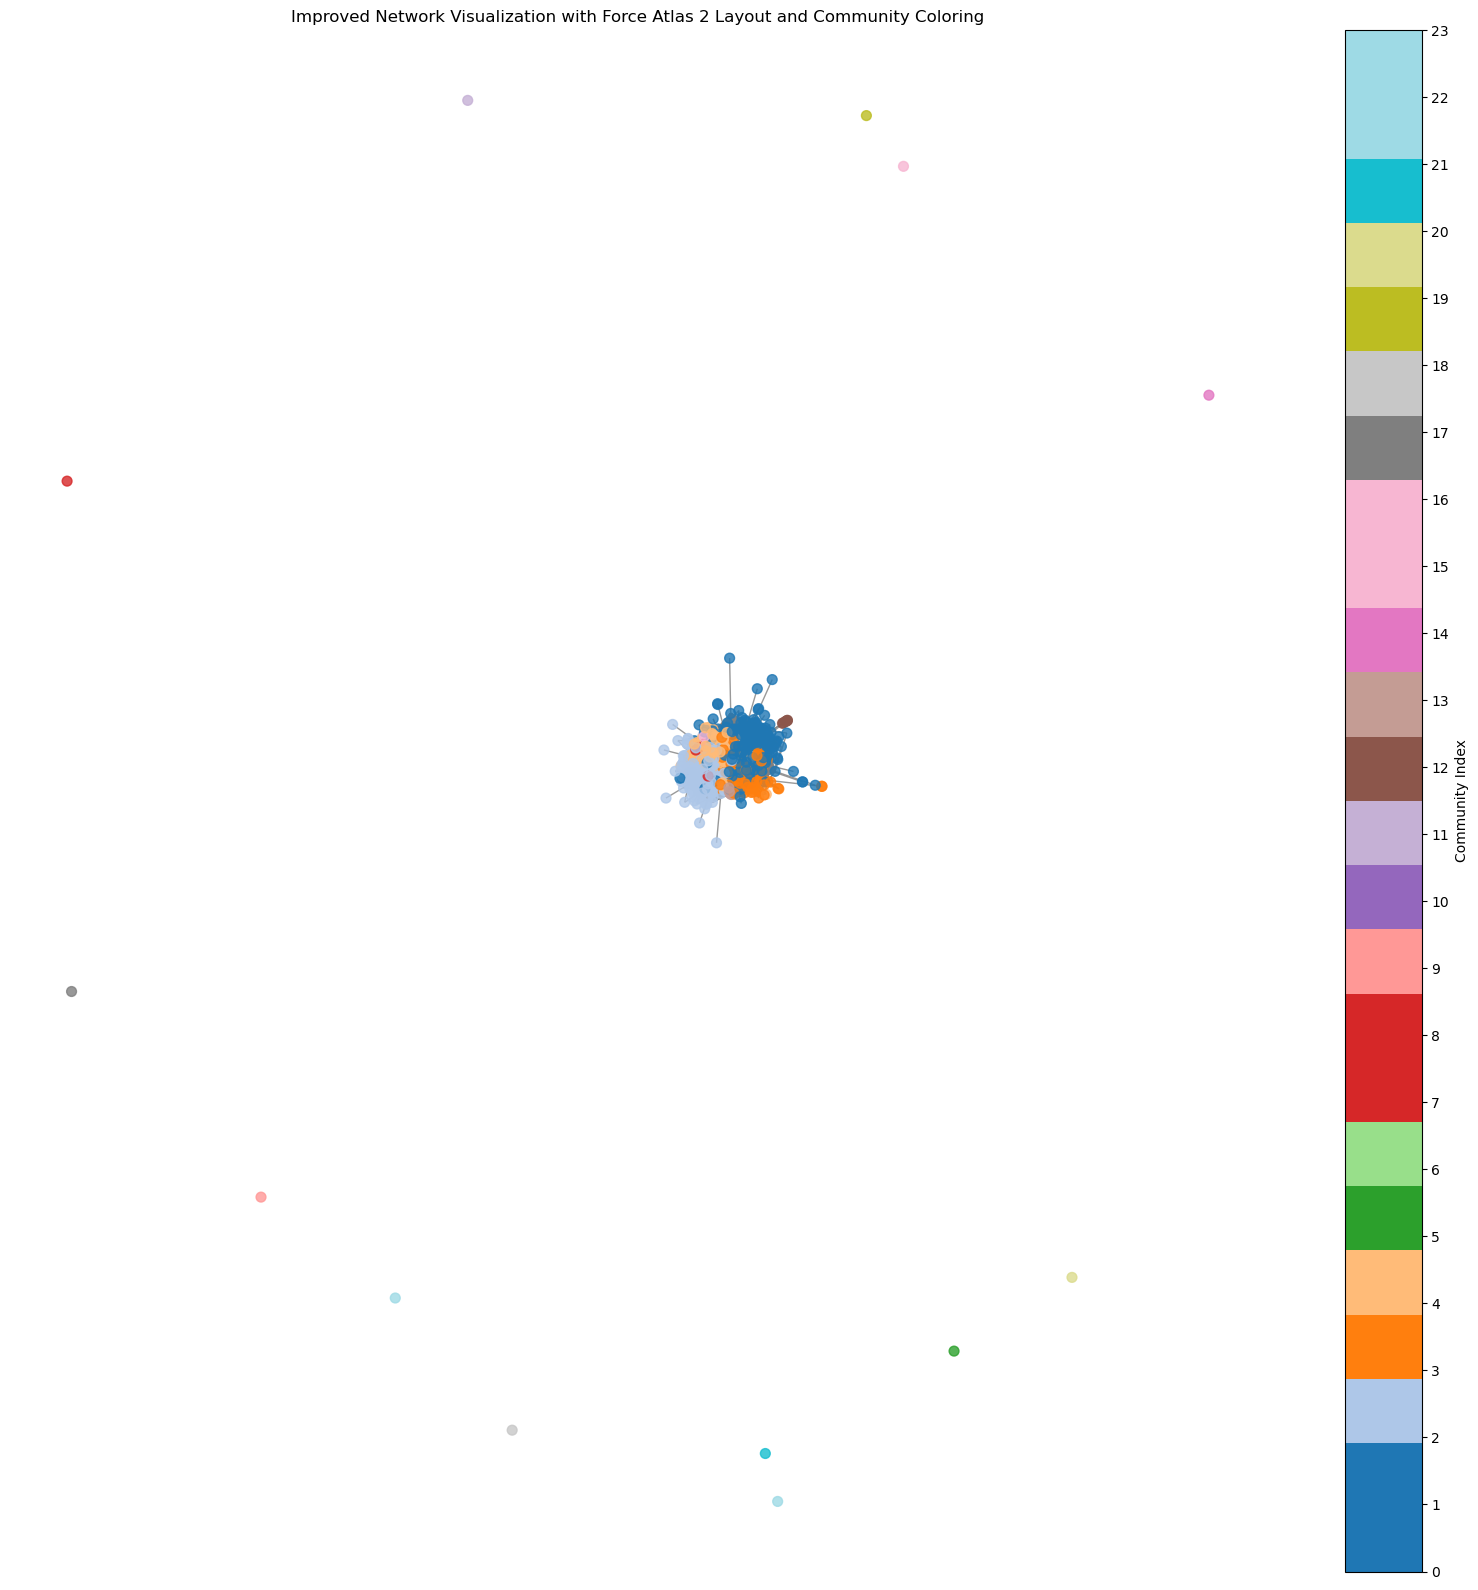

In [19]:
def apply_force_atlas_layout(G):
    forceatlas2 = ForceAtlas2(
        # Force Atlas 2 settings
        outboundAttractionDistribution=True,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        multiThreaded=False,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=True
    )
    # Get node positions from Force Atlas 2
    positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
    return positions

# Visualize the network using NetworkX's draw function
def visualize_graph(G, positions, partition):
    fig, ax = plt.subplots(figsize=(16, 16))  # 增加图像尺寸

    # 用社区作为节点颜色
    node_colors = [partition[node] for node in G.nodes()]
    node_sizes = [max(nx.degree(G, node)/100, 50) for node in G.nodes()]  # 增大节点大小以提高可见性

    # 绘制图形
    cmap = plt.cm.get_cmap('tab20', max(partition.values()) + 1)  # 动态调整色图范围
    nodes = nx.draw(
        G, 
        pos=positions, 
        node_color=node_colors, 
        node_size=node_sizes, 
        cmap=cmap,  # 用社区着色
        with_labels=False, 
        edge_color='gray', 
        alpha=0.8,  # 增加节点透明度
        ax=ax
    )

    # 添加基于社区的颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(node_colors), vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Community Index', orientation='vertical')
    cbar.set_ticks(range(max(partition.values()) + 1))  # 设置颜色条刻度
    cbar.set_ticklabels(range(max(partition.values()) + 1))

    plt.title('Improved Network Visualization with Force Atlas 2 Layout and Community Coloring')
    plt.tight_layout()  # 减少空白区域
    plt.show()

location = apply_force_atlas_layout(G_Lou)
visualize_graph(G_Lou, location, partition)


Ok, now in this final community exercise, we want to check if the genres align with the communities.


> *Exercise*: Communities versus genres.
> * Compare the communities found by your algorithm with the music genres by creating a matrix $D$ with dimension ($G \times C$), where G is the 7 most common genres and C is the 7 most common communities. We set entry $D(i,j)$ to be the number of nodes that genre $i$ has in common with community $j$. The matrix $D$ is what we call a confusion matrix.
> * Use the confusion matrix to explain how well the communities you've detected correspond to the genres.
>     * **Note**: This time, use all the genres associate with each node
>     * **Note**: If a node is not characterized by any of the 7 most popular genres, just ignore it.
>     * **Note**: If a node is not part of by any of the 7 largest communiteis, just ignore it.

<div class="alert alert-block alert-info">
Again, you may use an LLM to help with the code for this assignment. The main thing is you get the D matrix right and interpret it.
</div>

In [ ]:
# Identify the 7 most common genres
all_genres = [genre for genres in genres_data.values() for genre in genres]
most_common_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]

# Identify the 7 largest communities
community_sizes = {community: len(nodes) for community, nodes in genre_communities.items()}
largest_communities = sorted(community_sizes, key=community_sizes.get, reverse=True)[:7]

# Build the confusion matrix
D = np.zeros((7, 7))

# Map genres and communities to their indices for the matrix
genre_to_index = {genre: i for i, genre in enumerate(most_common_genres)} #[(0, 'country'), (1, 'folk'), (2, 'country rock'), (3, 'pop'), (4, 'americana'), (5, 'bluegrass'), (6, 'rock')]
community_to_index = {community: j for j, community in enumerate(largest_communities)} #[(0, 'country'), (1, 'pop'), (2, 'country pop'), (3, 'bluegrass'), (4, 'folk'), (5, 'americana'), (6, 'country rock')]

# Populate the matrix
for node, data in G_genres.nodes(data=True):
    # Get the genres and community of the node
    node_genres = genres_data.get(node, [])  #['neotraditional country', 'bluegrass']
    node_community = data.get('genre') # community of the node

    # Only consider nodes that match the 7 most common genres and largest communities
    if node_community in largest_communities:
        for genre in node_genres:
            if genre in most_common_genres:
                i = genre_to_index[genre]
                j = community_to_index[node_community]
                D[i, j] += 1

# Convert the matrix to a DataFrame for better readability
D_df = pd.DataFrame(D, index=most_common_genres, columns=largest_communities)

# Print the confusion matrix to see the values
print("Confusion Matrix D:")
print(D_df)


Confusion Matrix D:
              country   pop  country pop  bluegrass  folk  americana  \
country         645.0  73.0         54.0       55.0  61.0       38.0   
folk              0.0   8.0          1.0       12.0  65.0       20.0   
country rock      0.0   4.0         13.0        3.0   3.0        7.0   
pop               0.0  84.0          6.0        2.0   6.0        2.0   
americana         0.0   2.0          0.0        4.0  13.0       61.0   
bluegrass         0.0   1.0          2.0       70.0   8.0        9.0   
rock              0.0  13.0          2.0        3.0   7.0        4.0   

              country rock  
country               34.0  
folk                   3.0  
country rock          59.0  
pop                    5.0  
americana              1.0  
bluegrass              1.0  
rock                   2.0  


In [34]:
data.get('genre')

'neotraditional country'

# Part 3: Words that characterize pages or groups of pages

Now, we'll begin to play around with how far we can get with simple strategies for looking at text. 

The video is basically just me talking about a fun paper, which shows you how little is needed in order to reveal something highly interesting about humans that produce text. But it's important. Don't miss this one!

> **Video lecture**: Simple methods reveal a lot. I talk about the paper: [Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0073791).  

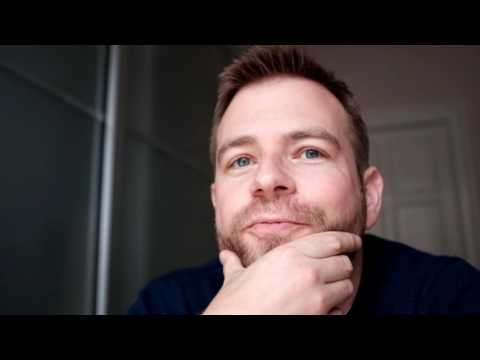

In [14]:
YouTubeVideo("wkYvdfkVmlI",width=800, height=450)

_Exercise_: Comparing in the different genres. 

*Setup*. You'll need to go to your archives and find the wikipedia pages of all the country artists. 

Once you have the texts ready, you will want to aggregate the text into 15 long lists, one for each of the top 15 genres (let's call them 15 *documents*). Each document contains on all the text in that genre (so for the country genre it's a looooong big doc). In each list, you should keep all the words (or *tokens* to be more precise) that occur on the pages, and a count of how frequently each word occurs. So the format should be

```
word0 count0
word1 count1
word2 count2

...

wordN countN
```
This list is called a ***Term Frequency*** (or TF) list for each community. Let's build our own TF lists. Before you start counting, I am going to ask you do do a few things

> *Action items*
> * Tokenize the pages into individual strings
> * Remove all punctuation from your list of tokens
> * Set everything to lower case
> * (Optional) Lemmatize your words
> * It's OK to filter out rare words (e.g. words that only appear less than 5 times).

If you are confused by the instructions for cleaning, go back and have a  look Chapter 3 again. 

> *Action item*: 
> * Create your TF list for each of the 15 most popular genres.
> * List the top 15 words for each genre.
> * Comment on the top 15 words for each genre.

<div class="alert alert-block alert-info">
It's OK to use an LLM to help with the code here, but write your own comments.
</div>

# Part 4: Visualization

**Step 1: Install the software**

First you must set up your system. The most difficult thing about creating the wordcloud is installing the `WordCloud` module. It's available on GitHub, check out the page [**here**](https://github.com/amueller/word_cloud). 

If you're lucky, you can simply install using conda (and all dependencies, etc will be automatically fixed): 

    conda install -c conda-forge wordcloud
 
If you can't get that to work you can refer here https://anaconda.org/conda-forge/wordcloud. 
Also, maybe the comments below are helpful: 
 * The module depends on the Python library PIL. If my experience generalizes, your life will be easier if you use `conda` to install that before you do anything else.
 * On my system, the module needed the `gcc` compiler installed. If you're not already a programmer, you may have to install that. On Mac you get it by installing the [_command line tools_](http://osxdaily.com/2014/02/12/install-command-line-tools-mac-os-x/). On linux, it's probably already installed. And on Windows I'm not sure, but we'll figure it out during the exercises. 
 * Once that's all set up, you can use `pip` to install the `WordCloud` library, as [detailed on the GitHub page](https://github.com/amueller/word_cloud). But don't forget to use Anaconda's `pip` just as when you installed the communities library a few weeks ago. 
 * There are examples of how to use the module online, see [here](http://sebastianraschka.com/Articles/2014_twitter_wordcloud.html) and [here](https://bioinfoexpert.com/2015/05/26/generating-word-clouds-in-python/). If you're interested, you can read about how the package was put together [here](http://peekaboo-vision.blogspot.dk/2012/11/a-wordcloud-in-python.html). 

**Step 2: Draw some wordclouds**

> *Action items*
> * Get your lists ready for the word-cloud software
>    - The package needs a single string to work on. The way that I converted my lists to a string was to simply combine all words together in one long string (separated by spaces), repeating each word according to its score (rounded up to the nearest integer value). 
>    - The `wordcloud` package looks for collocations in real texts, which is a problem when you make the list as above. The recommended fix is to simply set `collocations = False` as an option when you run the package.
> * Now, create a word-cloud for each genre. Feel free to make it as fancy or non-fancy as you like. Comment on the results. (If you'd like, you can remove stopwords/wiki-syntax - I did a bit of that for my own wordclouds.)

<div class="alert alert-block alert-info">
As above, it's OK to use an LLM to help get the code going. But write your own answers to the questions / write your own comments.
</div>

# Part 5: Understanding TF-IDF

Now we jump back into the NLP work. In this last part, we'll be creating word-clouds again. But this time, we'll be using the method from the paper I discuss above: TF-IDF. Historically people have had a hard time grasping the idea behind TF-IDF, so here's a little exercise designed to make you study it a bit more carefully.

*Exercise 4*: Wrap your brain around TF-IDF

First, let's learn about TF-IDF the way wikipedia explains it. Check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) and ***read the first part very carefully***. The idea is that the term frequency doesn't capture just what's special about a text. It also captures words that are just frequent in all text. 

This is clear from the top counts in one of my lists:

```
of 
in 
and 
the 
to 
a 
is
by
was
as
ref
with
first
 ```
 
You can fix some of this by removing stop-words (as is described in the book), but it's not enough. ***We want to pull out what's special about a particular text.*** 

To focus on just what's special, TF-IDF has two components: The *term frequency* (TF) and a *weight* (IDF). The weight draws on a larger corpus of text emphasize what's special about the text we're interested in.

Further, there are some extra things going on. For example, there are multiple definitions of TF. Above, we just looked at the raw counts.

> *Action items*
>   * Pick one of the alternative term frequency definitions. Explain why it might sometimes be prefereable to the raw count.
>   * What does IDF stand for? Answer in your own words.
>   * How does IDF draw on a larger corpus to extract what's special a certain text? Answer in your own words.

There are also multiple versions of IDF. Let's think about those for a moment.

> *Action items*
>   * All of the IDF versions take the log of the calculated weight. Why do you think that is?
>   * Explain why using IDF makes stopword removal less important.

<div class="alert alert-block alert-info">
The point of this exercise is to understand TF-IDF. So I encourage you to ask questions to an LLM to really understand the concept. Perhaps ask it to explain TF-IDF at the level of a high-school student. Once you've done that, then answer the questions in the action items on your own.
</div>

# Part 6: Genres and TF-IDF word-clouds

**But wait a minute!** Now we have all of the ingredients for a wonderful cocktail 😎

* We have genres - descriptions of related nodes in the network. 
* And you're an expert on TF-IDF, so you can extract words that characterize a text relative to everything that's going on.
* Finally, you can create nice WordCouds!

So let's put it all together. Let's use TF-IDF and wordcoulds to build a deeper understanding of the top communities.

Thus, the aim of this final part is to create genre wordclouds for the top 15 genres based on TF-IDF. 

For each genre, create a single document for each community consisting of all the cleaned text from all members of the community. So in the end, you should have 15 documents in total.

_Exercise_: Genre Word-clouds

> * Now that we have the community-texts, let's start by grabbing the TF lists from the exercise above (you may modify to use whichever version of TF you like). 
> * Next, calculate IDF for every word in every list (use whichever version of IDF you like). 
>   * Which base logarithm did you use? Is that important?
> * We're now ready to calculate TF-IDFs. Do that for each genre. 
>   * List the 10 top words for each genre accourding to TF-IDF. Are these 10 words more descriptive of the genre than just the TF? Justify your answer.
> * Create a wordcloud for each genre. 
> * Explain your creation. Do the wordclouds/TF-IDF lists enable you to understand the communities you have found (or is it just gibberish)? Justify your answer.

<div class="alert alert-block alert-info">
Overall, it's OK to use an LLM to help with the code. But do write your own answers to the questions.
</div>

*Exercise*: Community Word-clouds
> * Redo the exercise above but for the structural communities.
> * Do the word clouds seem more meaningful than for the genres? Add nuance to your answer by considering the confusion matrix $D$ that you calculated above.

<div class="alert alert-block alert-info">
Since this is optional, you can do wat you want with LLMs. Maybe you can get one to solve the whole exercise?
</div>